In [1]:
# @title Instalação do deap
! pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.4 MB/s eta 0:00:00


In [26]:
# @title Download dos dados de entrada (Asimétricos)

!wget http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/atsp/ft53.atsp.gz
!gunzip ft53.atsp.gz

!wget http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/atsp/rbg443.atsp.gz
!gunzip rbg443.atsp.gz

--2025-03-17 16:29:13--  http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/atsp/ft53.atsp.gz
Resolving comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)... 129.206.106.221
Connecting to comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)|129.206.106.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6031 (5.9K) [application/octet-stream]
Saving to: ‘ft53.atsp.gz’

ft53.atsp.gz        100%[===================>]   5.89K  --.-KB/s    in 0s      

2025-03-17 16:29:17 (482 MB/s) - ‘ft53.atsp.gz’ saved [6031/6031]

--2025-03-17 16:29:17--  http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/atsp/rbg443.atsp.gz
Resolving comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)... 129.206.106.221
Connecting to comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)|129.206.106.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103674 (101K) [application/octet-stream]
Saving to: ‘rbg443.atsp.gz’

rbg443.atsp.gz  

In [2]:
# @title Download dos dados de entrada (Simétricos)

!wget http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/brazil58.tsp.gz
!gunzip brazil58.tsp.gz

!wget http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/brg180.tsp.gz
!gunzip brg180.tsp.gz

--2025-03-17 16:21:02--  http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/brazil58.tsp.gz
Resolving comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)... 129.206.106.221
Connecting to comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)|129.206.106.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3947 (3.9K) [application/octet-stream]
Saving to: ‘brazil58.tsp.gz’

brazil58.tsp.gz     100%[===================>]   3.85K  --.-KB/s    in 0s      

2025-03-17 16:21:04 (419 MB/s) - ‘brazil58.tsp.gz’ saved [3947/3947]

--2025-03-17 16:21:04--  http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/brg180.tsp.gz
Resolving comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)... 129.206.106.221
Connecting to comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)|129.206.106.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4443 (4.3K) [application/octet-stream]
Saving to: ‘brg180.tsp.gz’

brg180.tsp.gz

In [57]:
# @title Import de Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time
import pytz
from datetime import datetime
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [65]:
# @title Função p/ leitura dos dados de entrada (Asimétricos)

# Retorna uma tupla (distancias, ncidades)
def read_data(fpath):
  distances, n_cities = None, None

  with open(fpath, "r") as f:
      lines = f.readlines()
      starting_i = 0
      for line in lines:
        starting_i +=1
        if 'EDGE_WEIGHT_SECTION' in line:
          break

        if 'DIMENSION' in line:
          n_cities = int(line.split()[-1])

      distances = np.zeros((n_cities,n_cities), dtype=np.int64)
      i, j = 0, 0
      for line in lines[starting_i:]:
        if 'EOF' in line or i >= n_cities:
          break

        for distance in line.split():
          if i==j: # Tratando os dados para facilitar a implementação
            distances[i][j] = 9999999 # Sair de i e ir para i é indesejável
          else:
            distances[i][j] = int(distance)
          j += 1
          if j >= n_cities:
            j = 0
            i += 1
  return distances, n_cities

In [58]:
# @title Função p/ leitura dos dados de entrada (Simétricos)

# Retorna uma tupla (distancias, ncidades)
def read_data(fpath):
  distances, n_cities = None, None

  with open(fpath, "r") as f:
      lines = f.readlines()
      starting_i = 0
      for line in lines:
        starting_i +=1
        if 'EDGE_WEIGHT_SECTION' in line:
          break

        if 'DIMENSION' in line:
          n_cities = int(line.split()[-1])

      distances = np.zeros((n_cities,n_cities), dtype=np.int64)
      i, j = 0, 1 # Os valores na diagonal não são apresentados
      for line in lines[starting_i:]:
        if 'EOF' in line or i >= n_cities:
          break

        for distance in line.split():
          distances[i][j] = int(distance)
          j += 1
          if j >= n_cities:
            i += 1
            j = i+1

  distances = distances + distances.T # Refletir a matriz

  for i in range(n_cities):
    distances[i][i] = 9999999 # Indesejável sair de i para i

  return distances, n_cities

In [66]:
filepath = 'rbg443.atsp' # @param {'type':'string'}
distances, n_cities = read_data(filepath)

print(f"Arquivo {filepath} lido com sucesso!")
print(f"Número de cidades: {n_cities}")
print("Matriz de distâncias:")
print(distances)


Arquivo rbg443.atsp lido com sucesso!
Número de cidades: 443
Matriz de distâncias:
[[9999999      11      10 ...      14      24      24]
 [      0 9999999      11 ...      15      24      24]
 [     11      12 9999999 ...      15      25      25]
 ...
 [     23      21      23 ... 9999999      12      12]
 [     12      14      11 ...      18 9999999      26]
 [     23      21      23 ...      16      14 9999999]]


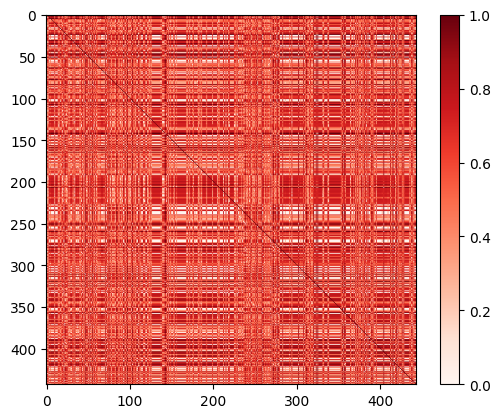

In [67]:
# @title Visualizando os dados...

def plot_matrix(matrix):

    # Copia
    matrix = matrix.copy()

    # Correção dos valores da diagonal:
    # 9999999 é um valor muito desproporcional, e acaba com a escala da representação gráfica.
    # Por isso é substituido pelo maior valor de fato encontrado no dataset
    np.fill_diagonal(matrix, np.sort(np.unique(matrix))[-2])

    # Normaliza os valores da matriz para o intervalo [0, 1]
    norm_matrix = (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))

    # Cria o gráfico
    fig, ax = plt.subplots()
    cax = ax.imshow(norm_matrix, cmap='Reds', origin='upper')

    # Exibe a barra de cores
    plt.colorbar(cax)
    plt.show()

# Exemplo de uso com uma matriz aleatória
plot_matrix(distances)

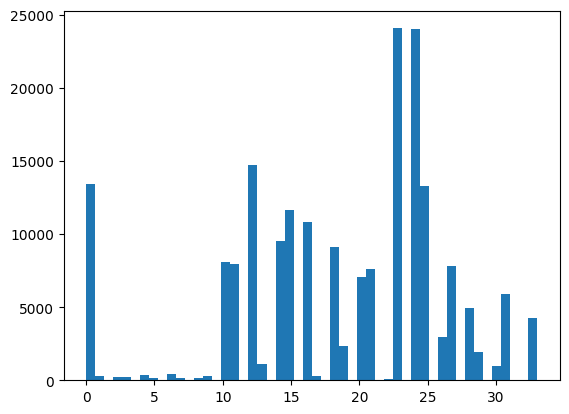

In [68]:
# @title Histograma dos dados

def plot_hist(matrix):

    # Copia
    matrix = matrix.copy()

    # Correção dos valores da diagonal:
    # 9999999 é um valor muito desproporcional, e acaba com a escala da representação gráfica.
    # Por isso é substituido pelo maior valor de fato encontrado no dataset
    np.fill_diagonal(matrix, np.sort(np.unique(matrix))[-2])

    plt.hist(matrix.flatten(), bins=50)

plot_hist(distances)

In [ ]:
# @title Minimização da FO

# Problema de minimização
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Indivíduo derivado de uma permutação
creator.create("Individual", list, fitness=creator.FitnessMin)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
# @title Criação da Toolbox + registros do indivíduo e população
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(n_cities), n_cities) # A solução é representada como um permutação
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual) # População é uma lista de indivíduos

In [ ]:
# @title Função Objetivo

def fitness(individual):
  distance = 0 # Distância total viajada
  for i in range(n_cities-1):
    distance += distances[individual[i]][individual[i+1]]
  distance += distances[individual[n_cities-1]][individual[0]] # Volta para a cidade original

  return distance, # Como a solução é uma permutação, não há necessidade de preocupar-se com infrações das restrições

In [ ]:
# @title Registro da FO + operadores (cruzamento, mutação e seleção)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxOrdered)  # Crossover ordenado
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)  # Mutação por troca de cidades
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
# @title Pipeline experimental

# Retorna (melhor rota, distância total percorrida na melhor rota, objeto de estatísticas, logbook)
def main(MU=300, LAMBDA_=300, CXPB=0.6, MUTPB=0.4, NGEN=500, SEED=None, verbose=True):
  if SEED is not None:
    random.seed(SEED)
  pop = toolbox.population(n=MU)  # População inicial
  hof = tools.HallOfFame(1)  # Melhor solução encontrada
  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("min", np.min)
  stats.register("avg", np.mean)

  # Evolução com algoritmo genético
  #algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=200, stats=stats, halloffame=hof, verbose=verbose)
  pop, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA_, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=verbose)
  #algorithms.eaMuCommaLambda(pop, toolbox, mu=100, lambda_=400, cxpb=0.7, mutpb=0.2, ngen=200, stats=stats, halloffame=hof, verbose=verbose)

  if verbose:
    print("\nMelhor rota encontrada:", hof[0])
    print("Distância total:", fitness(hof[0])[0])

  return hof[0], fitness(hof[0])[0], stats, log

# Tunando Hiperparâmetros

Nesta seção abaixo iremos fazer uma tunagem de hiperparâmetros em pares. Isto é, dado um par de hiperparâmetros, iremos testar algumas de suas combinações e selecionar a melhor.

Cada teste consistirá em 3 execuções. A configuração que vencer em mais testes será escolhida. Em caso de empate, o desempate será feito de maneira aleatória.

Vencer = ter a melhor FO condicionada a uma curva de convergência suave. Uma descida abrupta para o melhor valor será desconsiderada.

Os testes serão feitos com a brazil58.tsp

Pares definidos:
- μ e λ ⇒ (300, 200), (300, 300), (300, 500)
- Prob. Crossover e Prob. Mutação ⇒ (0.7, 0.3), (0.6, 0.4), (0.5, 0.5), (0.4, 0.6), (0.3, 0.7)


# μ e λ

In [ ]:
# @title μ e λ (Gráfico de convergência)

PAIRS = [(300, 200), (300, 300), (300, 500)]
COLORS = ['r', 'g', 'b']
BEST_FITS = []
LOGS = []

# Realização dos testes
for MU, LAMBDA_ in PAIRS:
  NGEN = 500
  _, f, _, log = main(NGEN=NGEN, MU=MU, LAMBDA_=LAMBDA_)
  BEST_FITS.append(f)
  LOGS.append(log)

# Plot gráfico
fig, ax1 = plt.subplots()
ax1.set_xlabel("Geração")
ax1.set_ylabel("FO", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

lns = []
for i, (MU, LAMBDA_) in enumerate(PAIRS):
  gen = list(range(NGEN+1))
  fit_mins = LOGS[i].select('min')
  line = ax1.plot(gen, fit_mins, f"{COLORS[i]}-", label=f"({MU}, {LAMBDA_}) FO Mínima")
  lns = lns + line

labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper right")

plt.show()

In [ ]:
# @title μ e λ (Melhores fitnesses)

print("Melhores fitness para cada par:")
for MU, LAMBDA_ in PAIRS:
  print(f"({MU}, {LAMBDA_}) -> {BEST_FITS[PAIRS.index((MU, LAMBDA_))]}")

print("\nMelhor par:")
print(PAIRS[BEST_FITS.index(min(BEST_FITS))])

# Resultados μ e λ

O melhor par é (300, 500) já que venceu em dois de três testes!

# Prob. Crossover e Prob. Mutação

In [ ]:
# @title Prob. Crossover e Prob. Mutação (gráfico de convergência)

PAIRS = [(0.7, 0.3), (0.6, 0.4), (0.5, 0.5), (0.4, 0.6), (0.3, 0.7)]
COLORS = ['r', 'g', 'b', 'k', 'm']
BEST_FITS = []
LOGS = []

# Realização dos testes
for CXPB, MUTPB in PAIRS:
  NGEN = 500
  _, f, _, log = main(MU=300, LAMBDA_=500, NGEN=NGEN, CXPB=CXPB, MUTPB=MUTPB)
  BEST_FITS.append(f)
  LOGS.append(log)

# Plot gráfico
fig, ax1 = plt.subplots()
ax1.set_xlabel("Geração")
ax1.set_ylabel("FO", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

lns = []
for i, (CXPB, MUTPB) in enumerate(PAIRS):
  gen = list(range(NGEN+1))
  fit_mins = LOGS[i].select('min')
  line = ax1.plot(gen, fit_mins, f"{COLORS[i]}-", label=f"({CXPB}, {MUTPB}) FO Mínima")
  lns = lns + line

labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper right")

plt.show()

In [ ]:
# @title Prob. Crossover e Prob. Mutação (Melhores fitnesses)

print("Melhores fitness para cada par:")
for CXPB, MUTPB in PAIRS:
  print(f"({CXPB}, {MUTPB}) -> {BEST_FITS[PAIRS.index((CXPB, MUTPB))]}")

print("\nMelhor par:")
print(PAIRS[BEST_FITS.index(min(BEST_FITS))])

# Resultados Prob. Crossover e Prob. Mutação

O melhor par é (0.5, 0.5) já que venceu em dois de três testes!

# Execução experimental

Execução 1 iniciando em: 2025-03-13 17:55:02.
Execução 1 finalizada. Tempo gasto (s): 185.81237769126892. Registrando os logs...
Execução 2 iniciando em: 2025-03-13 17:58:08.
Execução 2 finalizada. Tempo gasto (s): 186.23234009742737. Registrando os logs...
Execução 3 iniciando em: 2025-03-13 18:01:14.
Execução 3 finalizada. Tempo gasto (s): 187.14255213737488. Registrando os logs...
Execução 4 iniciando em: 2025-03-13 18:04:21.
Execução 4 finalizada. Tempo gasto (s): 184.57139325141907. Registrando os logs...
Execução 5 iniciando em: 2025-03-13 18:07:26.
Execução 5 finalizada. Tempo gasto (s): 185.7742326259613. Registrando os logs...
Execução 6 iniciando em: 2025-03-13 18:10:32.
Execução 6 finalizada. Tempo gasto (s): 184.82711553573608. Registrando os logs...
Execução 7 iniciando em: 2025-03-13 18:13:36.
Execução 7 finalizada. Tempo gasto (s): 186.09020471572876. Registrando os logs...
Execução 8 iniciando em: 2025-03-13 18:16:43.
Execução 8 finalizada. Tempo gasto (s): 185.08560466

<ipython-input-11-9adba44256f0>:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(FITNESSES, labels=[""])


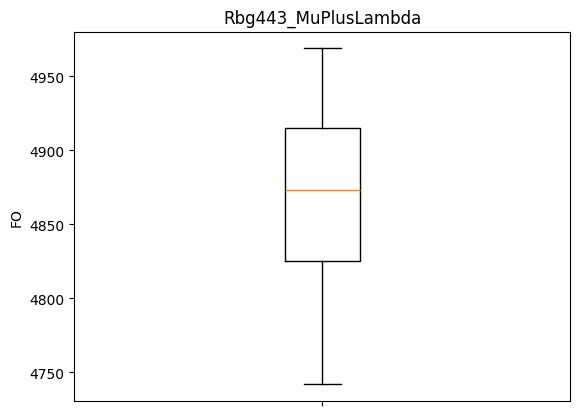

In [ ]:
# @title Execução e registro dos logs

LOG_BASE_DIR = "/content/drive/MyDrive/ResultadosCompEvolutiva"
EXPERIMENT_NAME = "Rbg443_MuPlusLambda" # @param {type:"string"}
OPTIMAL_VALUE = 2720 # @param {type:"number"}
N = 33
NOTES = "mu=300, lambda_=500, cxpb=0.5, mutpb=0.5, ngen=500, OPTIMAL_VALUE=2720" # @param {type:"string"}

# Criando o diretório de log
LOG_DIR = os.path.join(LOG_BASE_DIR, EXPERIMENT_NAME)
os.makedirs(LOG_DIR)

# Metadados
timezone_sao_paulo = pytz.timezone("America/Sao_Paulo")
date_time_now = datetime.now(timezone_sao_paulo)
with open(os.path.join(LOG_DIR, 'notes.txt'), "w+") as f:
  f.write(f"Experimento começando em: {date_time_now.strftime('%Y-%m-%d %H:%M:%S')}")
  f.write("\nNotas sobre o experimento estão registradas abaixo\n")
  f.write(NOTES)

# Resultados: desempenho
with open(os.path.join(LOG_DIR, 'results.csv'), "w+") as f:
  f.write("index,best_fitness,time_in_seconds\n")

# Resultados: caminhos encontrados
with open(os.path.join(LOG_DIR, 'paths.csv'), "w+") as f:
  f.write("index,path\n")

# Resultados: seeds para reproducibilidade
with open(os.path.join(LOG_DIR, 'seeds.csv'), "w+") as f:
  f.write("index,seed\n")

# Resultados: melhor fitness obtido em cada geração de uma execução
with open(os.path.join(LOG_DIR, 'logs.csv'), "w+") as f:
  f.write("index,min_fit_through_gens\n")

# Experimentação de fato
NGEN = 500
FITNESSES = []
TIMES = []
for i in range(N):
  SEED = np.random.randint(1000000) # de zero a um milhao
  print(f"Execução {i+1} iniciando em: {datetime.now(timezone_sao_paulo).strftime('%Y-%m-%d %H:%M:%S')}.")
  start = time.time()
  h, f, _, logs = main(NGEN=NGEN, MU=300, LAMBDA_=500, CXPB=0.5, MUTPB=0.5, verbose=False)
  end = time.time()
  print(f"Execução {i+1} finalizada. Tempo gasto (s): {end-start}. Registrando os logs...")

  FITNESSES.append(f)
  TIMES.append(end-start)

  # Logs
  with open(os.path.join(LOG_DIR, 'results.csv'), "a") as file_:
    file_.write(f"{i},{f},{end-start}\n")

  with open(os.path.join(LOG_DIR, 'paths.csv'), "a") as f:
    f.write(f"{i},{h}\n")

  with open(os.path.join(LOG_DIR, 'seeds.csv'), "a") as f:
    f.write(f"{i},{SEED}\n")

  with open(os.path.join(LOG_DIR, 'logs.csv'), "a") as f:
    f.write(f"{i},{logs.select('min')}\n")

def gap(melhor_solucao_encontrada, solucao_otima):
  return 100*((melhor_solucao_encontrada - solucao_otima)/solucao_otima)

# Resultados: agregados
with open(os.path.join(LOG_DIR, 'results_aggregated.csv'), "w+") as f:
  f.write(f"type,worst,best,mean,std,gap\n")
  f.write(f"fitness,{max(FITNESSES)},{min(FITNESSES)},{np.mean(FITNESSES)},{np.std(FITNESSES)},{gap(min(FITNESSES), OPTIMAL_VALUE)}\n")
  f.write(f"time,{max(TIMES)},{min(TIMES)},{np.mean(TIMES)},{np.std(TIMES)},-\n")

# Resultados: Boxplot
plt.boxplot(FITNESSES, labels=[""])
plt.title(EXPERIMENT_NAME)
plt.ylabel("FO")


plt.savefig(os.path.join(LOG_DIR, 'boxplot.png'), dpi=300, bbox_inches="tight")
plt.show()
